# Awesome aligner benchmark
I test the performance of awesome aligner on NVIDIA GeForce GTX 1080 Ti. I measure the average time to complete one request for different *batch sizes*, *request sizes* and *sequence sizes*.

**One request** is supposed to model the situation that one user sends a request to align N sentence pairs. **One request** is composed of:
- N sentence pairs (N=request_size)
- each sentence has M tokens (M=sequence_size)
    - (so the actual token length of the sentence pair fed into the model is 2M+3, because we have two sentences and three special boundary tokens)

I measure the time (in seconds) it takes to complete **one request**. This depends on the *batch size* setting. For *batch size* = 1, the model is called N times for each sentence pair. Larger batch sizes result in less calls.

The benchmark script is in `benchmark_align.py`.

In [24]:
import pandas as pd

In [25]:
df = pd.read_csv("./benchmark_align_optimized.csv", index_col=0)

In [26]:
df["time_per_req"] = df["time"] / df["iters"]

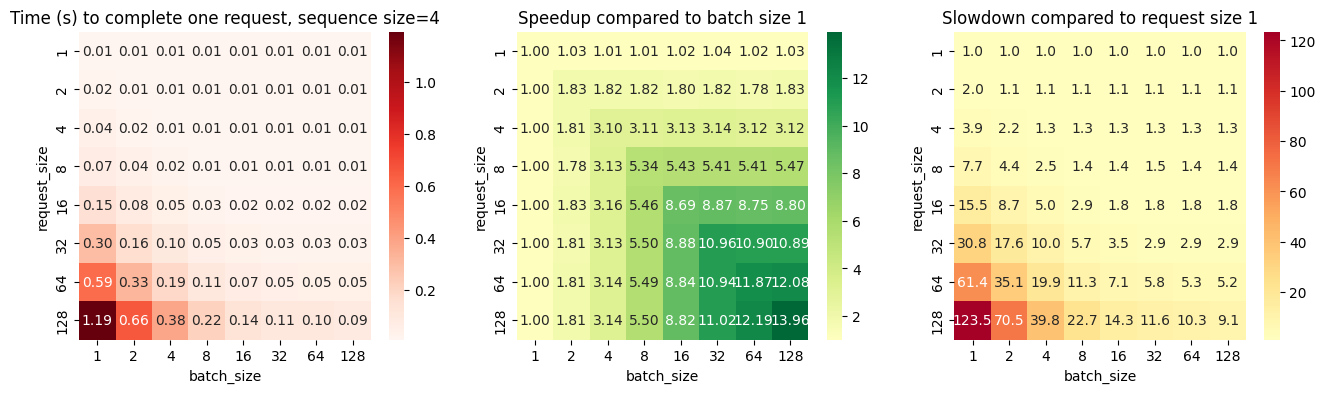

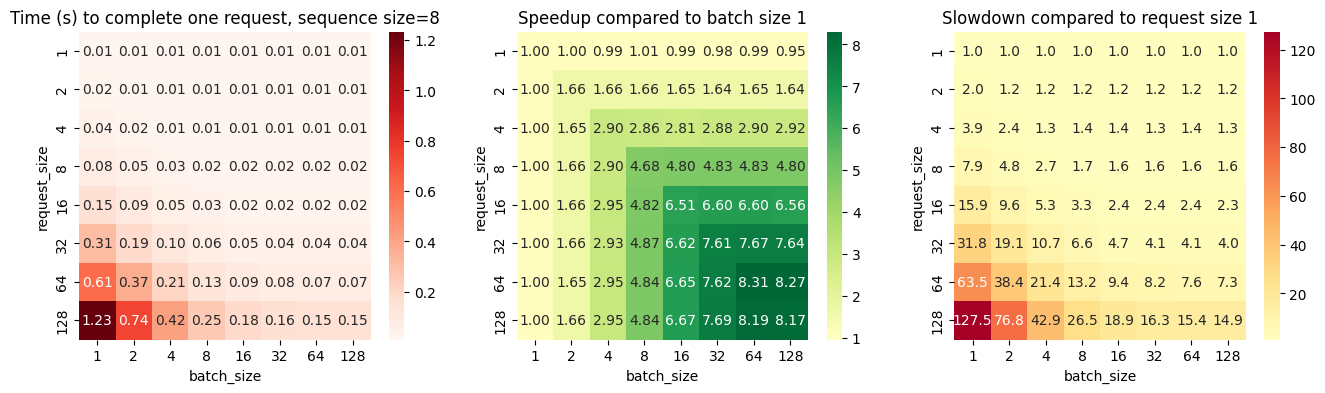

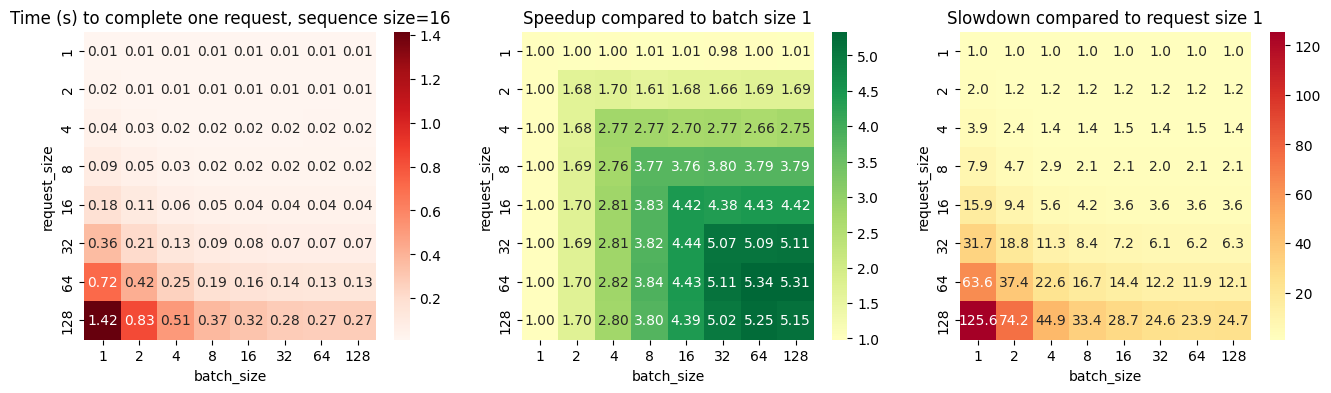

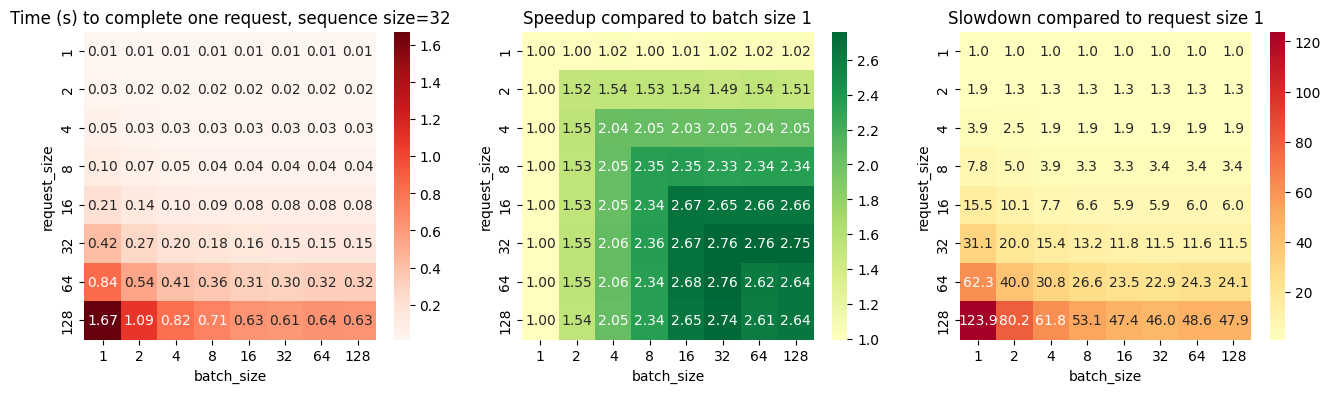

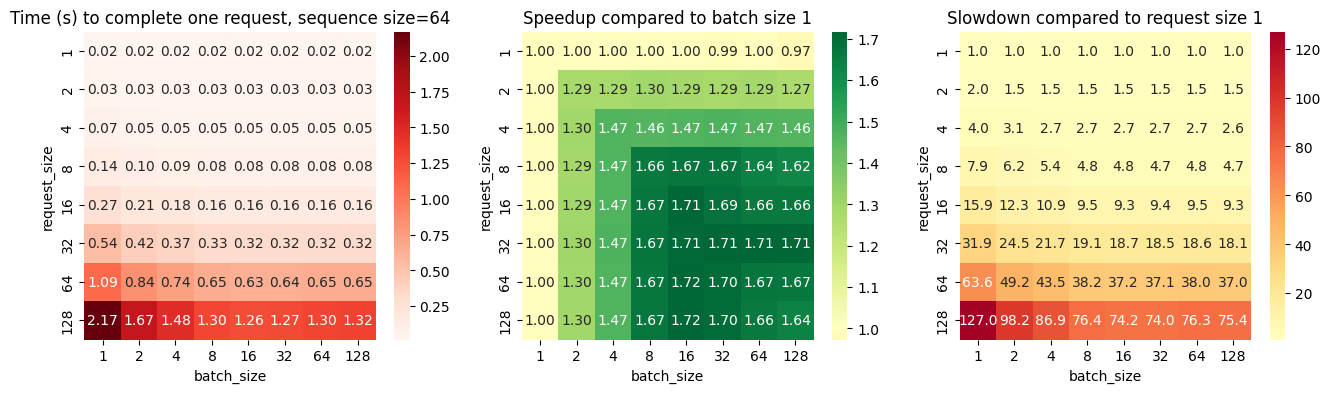

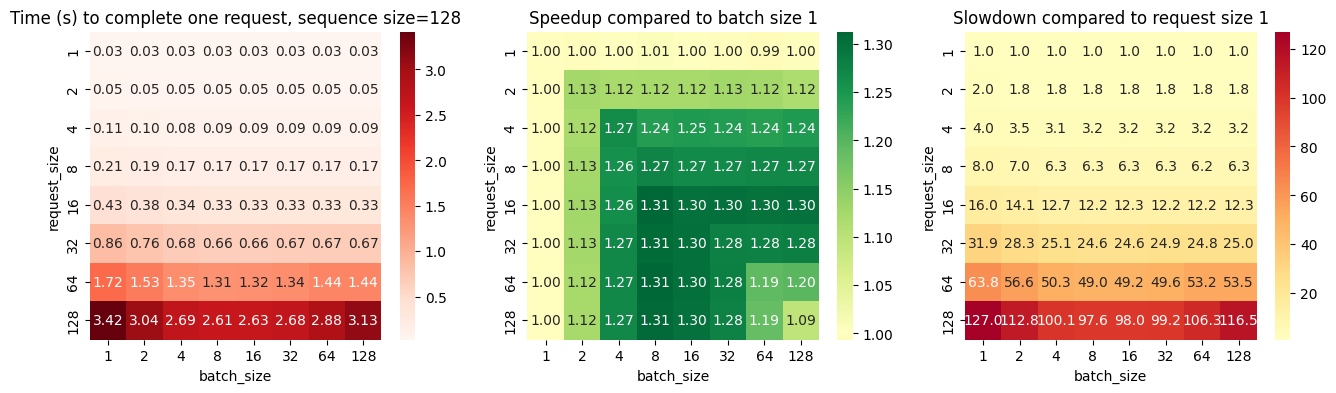

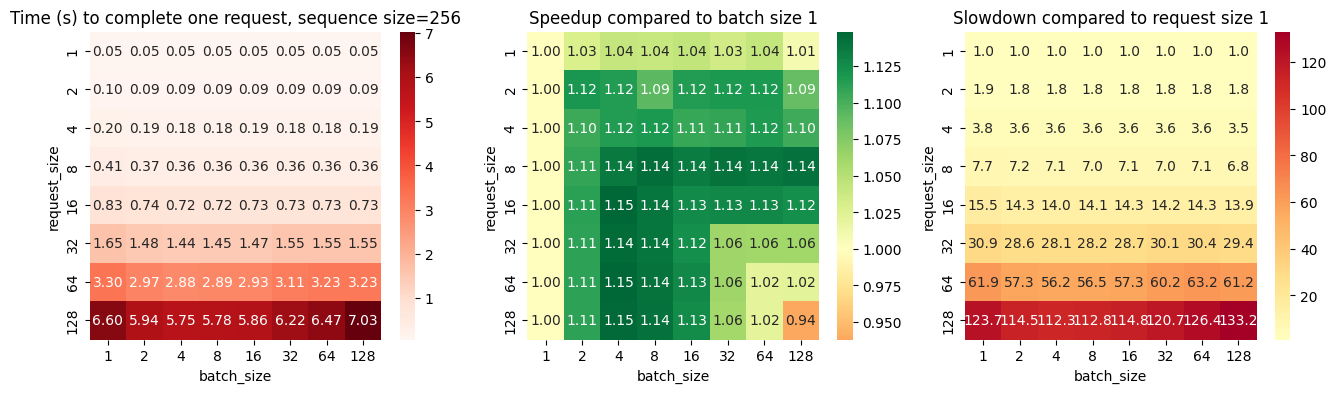

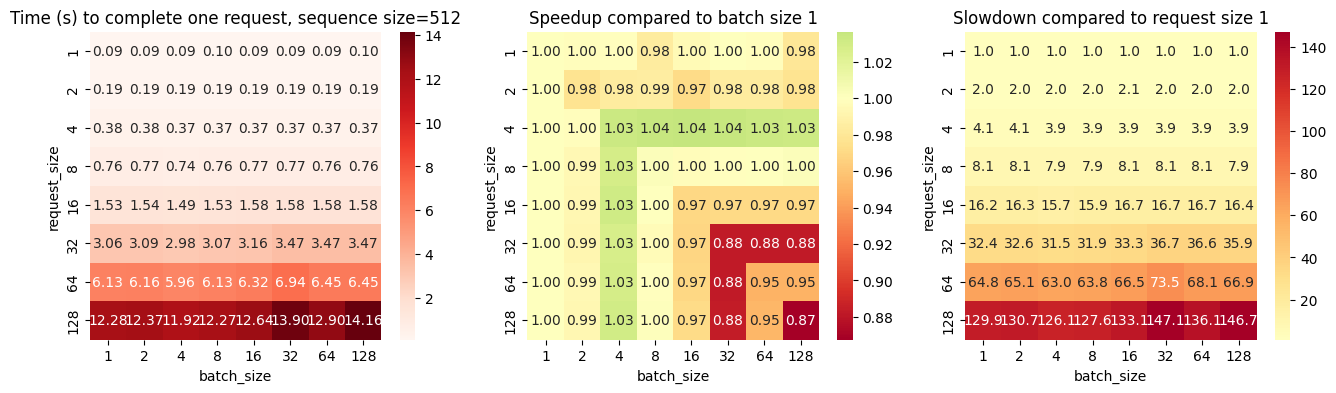

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# plot heatmap
for sequence_size in df["sequence_size"].unique():
    # print(sequence_size)
    pivot = df[df["sequence_size"] == sequence_size]
    pivot = pivot.pivot(index="request_size", columns="batch_size", values="time_per_req")
    # display(pivot)
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    sns.heatmap(pivot, annot=True, fmt='.2f', ax=axs[0], cmap="Reds")
    axs[0].set_title(f"Time (s) to complete one request, sequence size={sequence_size}")
    speedup_vs_bs1 = 1/pivot.divide(pivot[1], axis=0)
    sns.heatmap(speedup_vs_bs1, annot=True, fmt='.2f', ax=axs[1], cmap="RdYlGn", center=1)
    axs[1].set_title(f"Speedup compared to batch size 1")
    slowdown_vs_rs1 = pivot.divide(pivot.iloc[0], axis=1)
    sns.heatmap(slowdown_vs_rs1, annot=True, fmt='.1f', ax=axs[2], cmap="RdYlGn_r", center=1)
    axs[2].set_title(f"Slowdown compared to request size 1")
    plt.show()

Pozorování:
- Větší batch size je téměř vždy rychlejší nebo stejná jako bs=1
    - jediné, kde to neplatí jsou velmi dlouhé sekvence a velké batches. Tam se optimální bs posouvá směrem k 4-32, vyšší už jsou horší.
- Největší rozdíly jsou, když chce uživatel alignovat mnoho krátkých vět. Pak se velmi vyplatí nastavit batchsize vyšší než 1.
- Čím delší věty v requestu, tím menší je výhoda batchingu. Pomůže ale vždy.
- Zdá se mi, že je v alignmentu nějaký velký overhead krom samotného spuštění modelu. Když se podívám na batch size 1, tedy když model nemůže čerpat z paralelizace a porovnám čas potřebný ke zpracování requestu velikosti 1 a requestu velikosti 8, tak potřebný čas není 8x větší, ale jen 1.5-3x větší. Je tam nějaká velká absolutní složka, která ta zrychlení zakrývá.

In [15]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# # plot heatmap
# for sequence_size in df["sequence_size"].unique():
#     # print(sequence_size)
#     df_bs1 = df[(df["sequence_size"] == sequence_size) & (df["batch_size"] == 1)]
#     df_bs32 = df[(df["sequence_size"] == sequence_size) & (df["batch_size"] == 32)]
#     sns.lineplot(df_bs1, x="request_size", y="time_per_req", label="batch_size=1")
#     sns.lineplot(df_bs32, x="request_size", y="time_per_req", label="batch_size=32")
#     plt.title(f"Time (s) to complete one request, sequence size={sequence_size*2+4}")
#     # plt.xscale('log')
#     plt.show()